In [210]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
hfont = {'fontname':'Helvetica'}

## read data 
CIP_data = pd.read_csv("CIP_data_encode_prev.csv")
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


In [ ]:
########### GRAPH SHOWING TRENDS IN RESISTANCE ###########
### Overall data 
xAxisYears = [2000, 2005, 2010, 2015, 2019]
years = CIP_data_no_drop["YEAR"].unique()
reistance_by_year_overall = []
reistance_by_year_all = pd.DataFrame() 
for year in years:
    CIP_data_year = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    reistance_by_year_overall.append(1 - CIP_data_year["Susceptible"].sum()/len(CIP_data_year))


fig, (ax1, ax2) = plt.subplots(1, 2)
plt.setp(ax1, xlim=(2000, 2020), ylim=(0,.50), xticks=[2000, 2005, 2010, 2015, 2019])
plt.setp(ax2, xlim=(2000, 2020), ylim=(0,.50), xticks=[2000, 2005, 2010, 2015, 2019])
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=1.4)
## By region

regions = CIP_data_no_drop["REGION"].unique()

plt.subplot(1, 2, 1) 
#plt.subplots(figsize=(7.5, 3.75))

for region in regions:
    CIP_data_region = CIP_data_no_drop.loc[CIP_data_no_drop['REGION'] == region]
    reistance_by_year = []
    for year in years:
        CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == year]

        reistance_by_year.append(1 - CIP_data_region_year["Susceptible"].sum()/len(CIP_data_region_year))
    ax1.plot(years, reistance_by_year, label=region, alpha=0.75)

ax1.plot(years, reistance_by_year_overall, color = "black", label = "Overall")

legend_labels = [regions, 'Overall']


### By gender of sp 
genders = CIP_data_no_drop["GENDERSP"].unique()

plt.subplot(1, 2, 1) 
#plt.subplots(figsize=(7.5, 3.75))

#reistance_by_year_all = pd.DataFrame()
for gender in genders:
    CIP_data_region = CIP_data_no_drop.loc[CIP_data_no_drop['GENDERSP'] == gender]
    reistance_by_year = []
    for year in years:
        CIP_data_region_year = CIP_data_region.loc[CIP_data_region['YEAR'] == year]

        reistance_by_year.append(1 - CIP_data_region_year["Susceptible"].sum()/len(CIP_data_region_year))
        
    ax2.plot(years, reistance_by_year, label=gender, alpha=0.75)

ax2.plot(years, reistance_by_year_overall, color = "black", label = "Overall")

legend_labels = [genders, 'Overall']
ax1.set_xlabel('Year', fontsize = 16.0)
ax1.set_ylabel('Percent with ciprofloxacin resistance', fontsize = 16.0)
ax2.set_xlabel('Year', fontsize = 16.0)
ax1.legend()
ax2.legend(loc="upper left")
#ax1.annotate("A", xy=(0, 0.51), xycoords=trans,annotation_clip=False)
ax1.text(ax1.get_xlim()[0] , ax1.get_ylim()[1] + 0.01, 'A', fontsize = 16, **hfont)
ax2.text(ax1.get_xlim()[0] , ax1.get_ylim()[1] + 0.01, 'B', fontsize = 16, **hfont)

#ax1.set_title('ax1 title')
#ax2.set_title('ax2 title')

#plt.tight_layout()
print(ax1.get_xlim())
print(ax1.get_ylim())

#plt.savefig('Trends_in_ciprofloxacin_reisistance_region_gendersp.png')

In [ ]:
### Hyperparameter tuning with entire dataset 

## now do hyperparameter tuning again post PI
space = dict()
#space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)[1:6]
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=10)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =  1.29, random_state=10, learning_rate = 'adaptive' )

X = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y = 1 - CIP_data_no_drop['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X, y = oversample.fit_resample(X,y)
model_fit = model_nn.fit(X, y)

search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#Best Score: 0.8081387251717022
#Best Hyperparameters: {'learning_rate': 'adaptive', 'hidden_layer_sizes': 14, 'alpha':1.291549665014884}


In [71]:
### Permutation importance w/ hyperparameters and ENTIRE dataset 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 14, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#train data: 2000 - 2010
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network = metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_nn:', ROC_AUC_neural_network) 

print(ROC_AUC_neural_network)
perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())




ROC_AUC_nn: 0.6133720679704389
0.6133720679704389


Weight,Feature
0.1089 ± 0.0022,PREV_REGION
0.0255 ± 0.0010,PREV_CLINIC
0.0150 ± 0.0030,West
0.0126 ± 0.0012,DELTA_REGION
0.0117 ± 0.0022,MSM
0.0043 ± 0.0011,Southeast
0.0040 ± 0.0012,Southwest
0.0007 ± 0.0004,MSMW
0.0006 ± 0.0002,Oth/Unk/Missing
0.0000 ± 0.0007,Northeast


In [74]:
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change']

PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 100, random_state = 42)
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}"
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")

Prev. Region0.109 +/- 0.001
Prev. Clinic0.024 +/- 0.001
West    0.014 +/- 0.001
Change  0.013 +/- 0.001
MSM     0.012 +/- 0.001
Southeast0.004 +/- 0.001
Southwest0.004 +/- 0.001
MSMW    0.001 +/- 0.000
Oth/Unk/Missing0.000 +/- 0.000
Northeast0.000 +/- 0.001
MSW     -0.008 +/- 0.001
Midwest -0.014 +/- 0.001


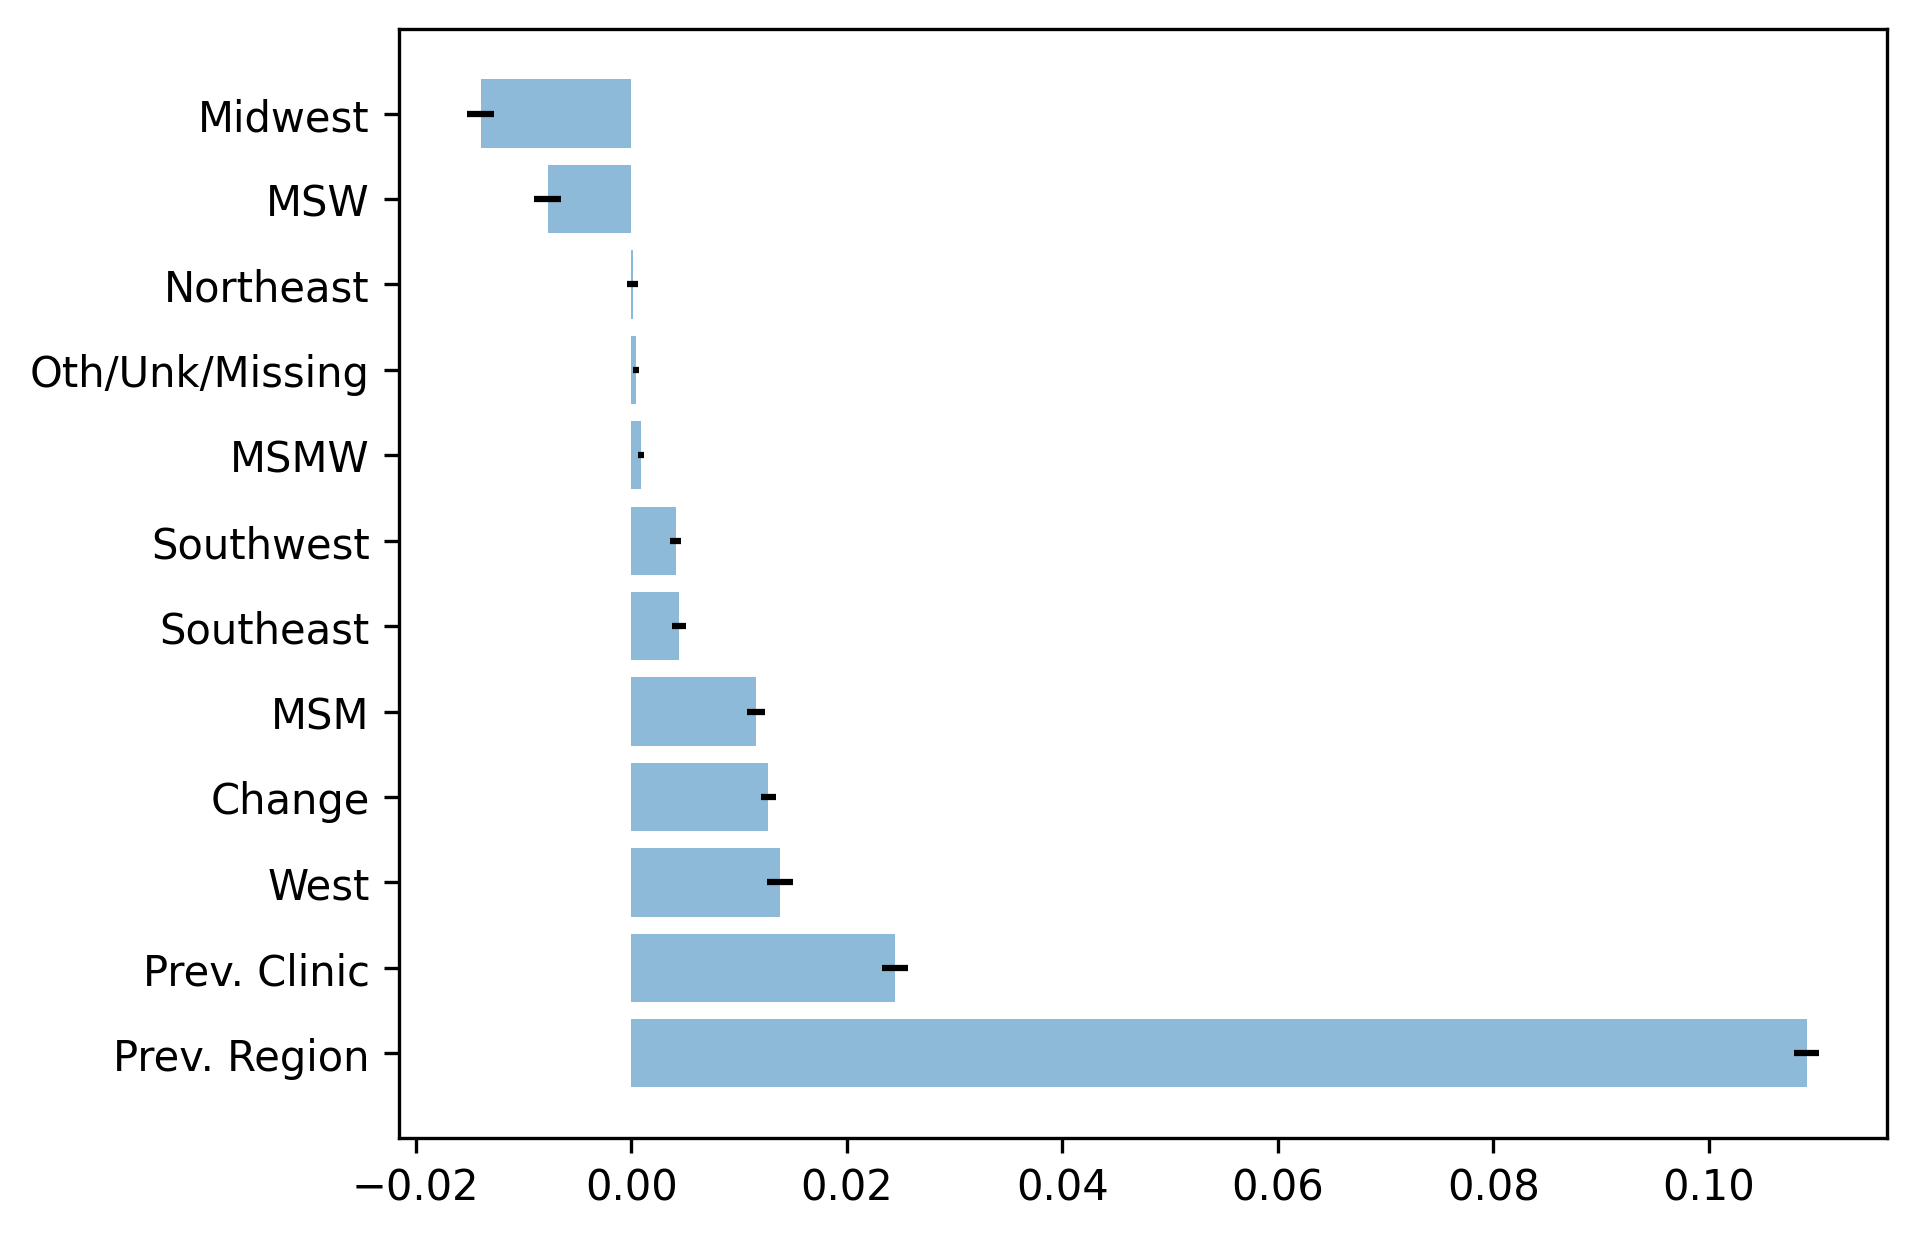

In [75]:
### graph feature engineering results 
feature_names = np.array(feature_names)
feature_names_by_importance = feature_names[PI.importances_mean.argsort()[::-1]]
mean_importance_by_importance = PI.importances_mean[PI.importances_mean.argsort()[::-1]]
std_importance_by_importance = PI.importances_std[PI.importances_mean.argsort()[::-1]]

plt.barh(y = range(mean_importance_by_importance.size), width =mean_importance_by_importance,
 xerr= std_importance_by_importance, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
plt.yticks(range(feature_names_by_importance.size), feature_names_by_importance)

plt.savefig('Features_by_importance_post_hyperparameter.png')


In [ ]:
#### Do hyperparameter tuning again post feature engineering (esp for hidden layer size)

space = dict()
#space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(11),(12), (13), (14)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =  0.46415888336127786, random_state=10, learning_rate = 'adaptive' )

X = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y = 1 - CIP_data_no_drop['Susceptible']
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X, y = oversample.fit_resample(X,y)
model_fit = model_nn.fit(X, y)

search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#Best Hyperparameters: {'learning_rate': 'adaptive', 'hidden_layer_sizes': 12, 'alpha':1.291549665014884}

In [83]:
###### Specificity and sensitivity of model on entire dataset
###### Dropping MSW and Midwest 

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha = 1.291549665014884, random_state=10, learning_rate = 'adaptive' )

#loop setup
threshold_seq = np.linspace(0,1,101)

#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

 #1. Create model using all data and get the apparent sensitivity and specificty 

model_fit_train = model_nn.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
#dataframes
sensitivity_test_threshold = []
specificity_test_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  #print(threshold)
 
 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  # Save results
  sensitivity_test_threshold.append(sensitivity_test)
  specificity_test_threshold.append(specificity_test)

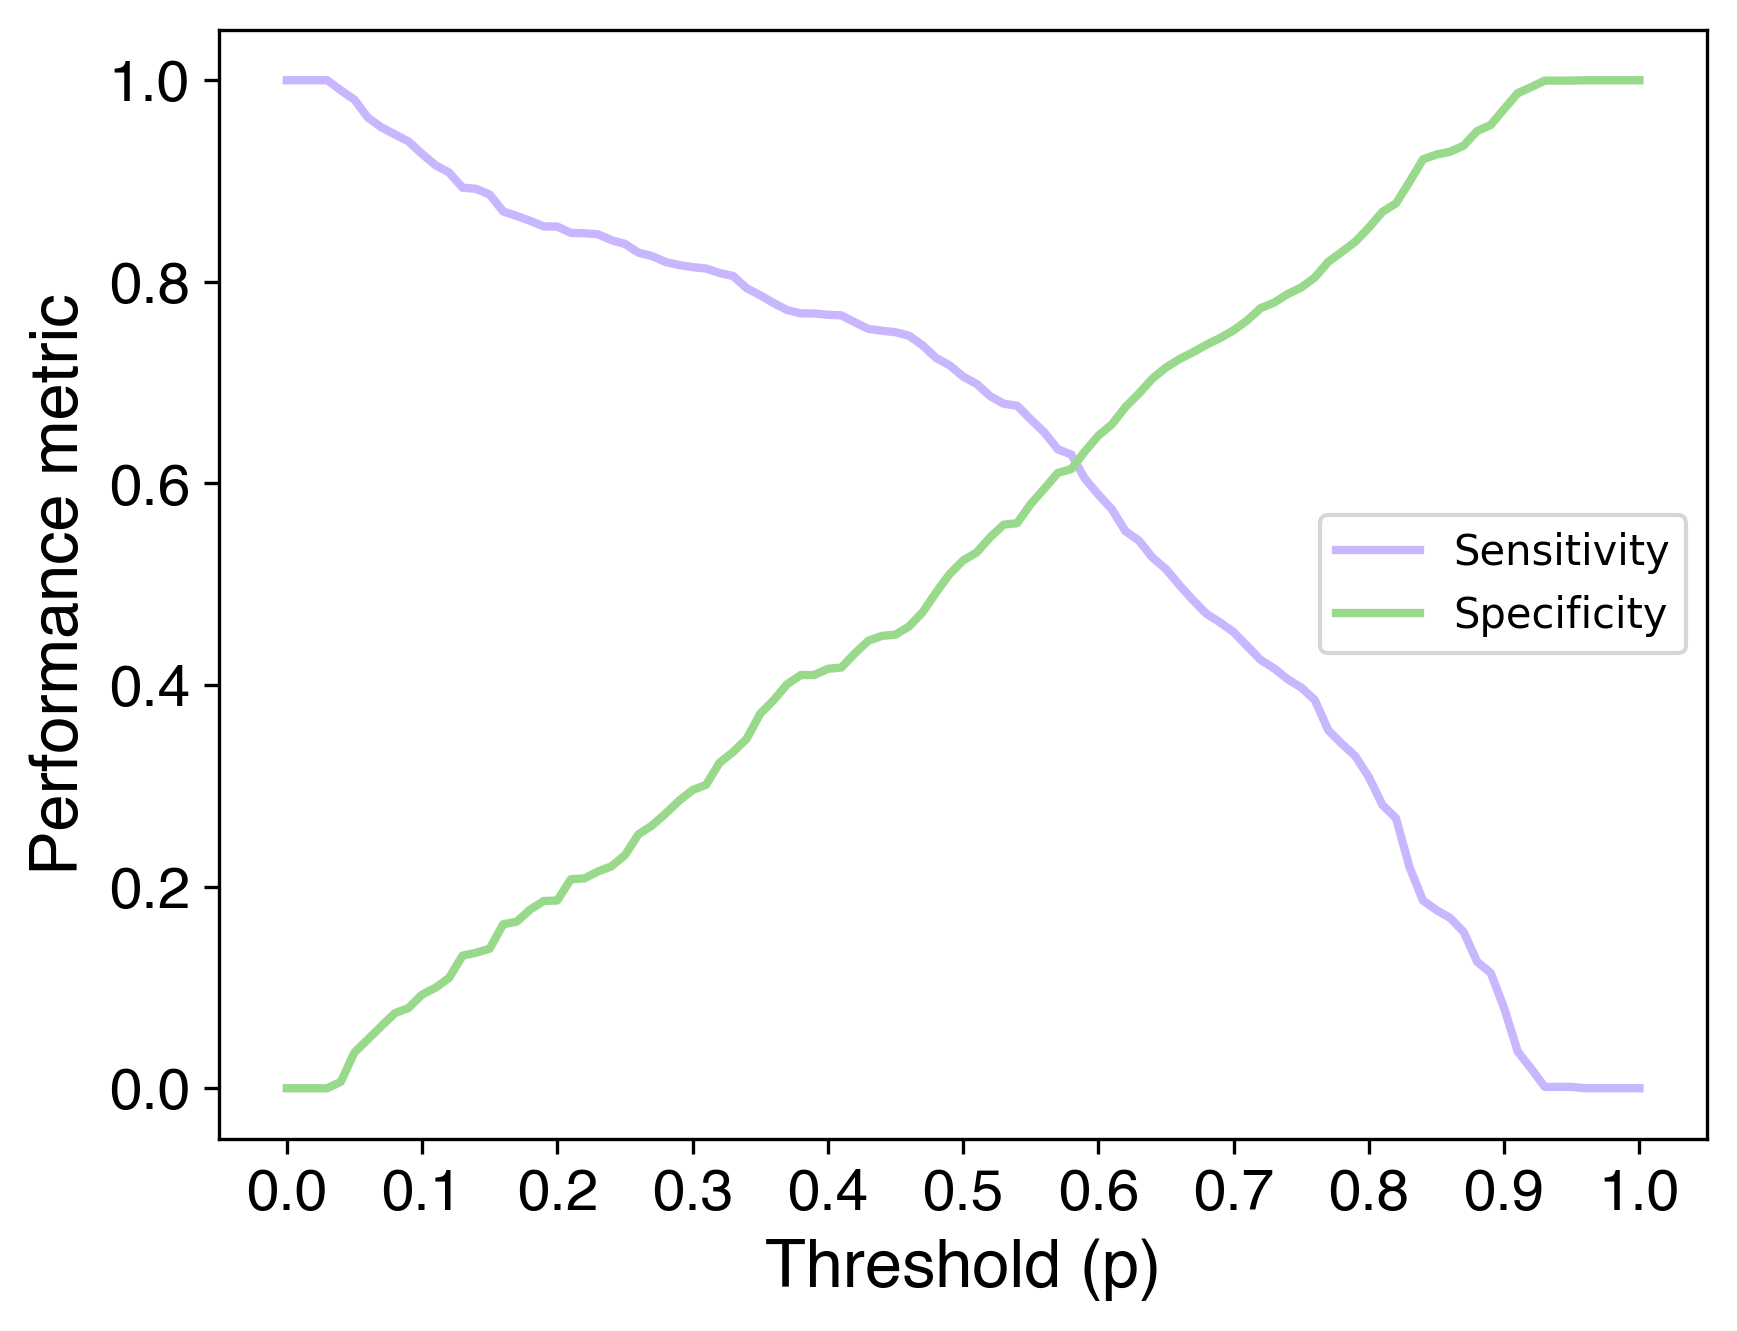

In [85]:
##### Graph of sensitivity and specificity 
hfont = {'fontname':'Helvetica'}

plt.rcParams['figure.dpi'] = 300
#plt.figure(figsize=(5.4,3.8))
sensitivity_test_threshold = pd.DataFrame(sensitivity_test_threshold)
specificity_test_threshold = pd.DataFrame(specificity_test_threshold)
threshold_seq = np.linspace(0,1,101)

plt.plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity", linewidth = 2)
plt.plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity", linewidth = 2)
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")

plt.xlabel("Threshold (p)", fontsize=16, **hfont)
plt.ylabel("Performance metric", fontsize=16,**hfont)
plt.xticks(np.linspace(0,1,11), fontsize=14,**hfont)
plt.yticks(np.linspace(0,1,6), fontsize=14,**hfont)

plt.legend()
#plt.savefig('Sensitivity_specificity_all_workflow_paper.png')

In [109]:
### auROC after feature engineering on entire test dataset dropping MSW and Midwest and two rounds of PI 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#train data: 2000 - 2010
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW',  'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
cipro_R_prev_all= y_test.sum()/len(y_test) #get prevalence overall before radndom oversampling
print(cipro_R_prev_all)
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network = metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_nn:', ROC_AUC_neural_network) 

0.23081886682486158
ROC_AUC_nn: 0.6148310841503746


In [110]:
########### Now do proportion receiving effective and unnecessary treatment for overall testing data
### can use model from the previous cell 

### Loop over thresholds to see how classification threshold affects proportion receiving effective and unnecessary treatment ALL TEST DATA
threshold_seq = np.linspace(0,1,101)

get_effective_threshold = []
incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  get_effective_threshold.append(sensitivity_test * cipro_R_prev_all + (1 -  cipro_R_prev_all)) #q_p
  incorrectly_get_X_threshold.append((1 - cipro_R_prev_all) * (1 - specificity_test)) #c_p


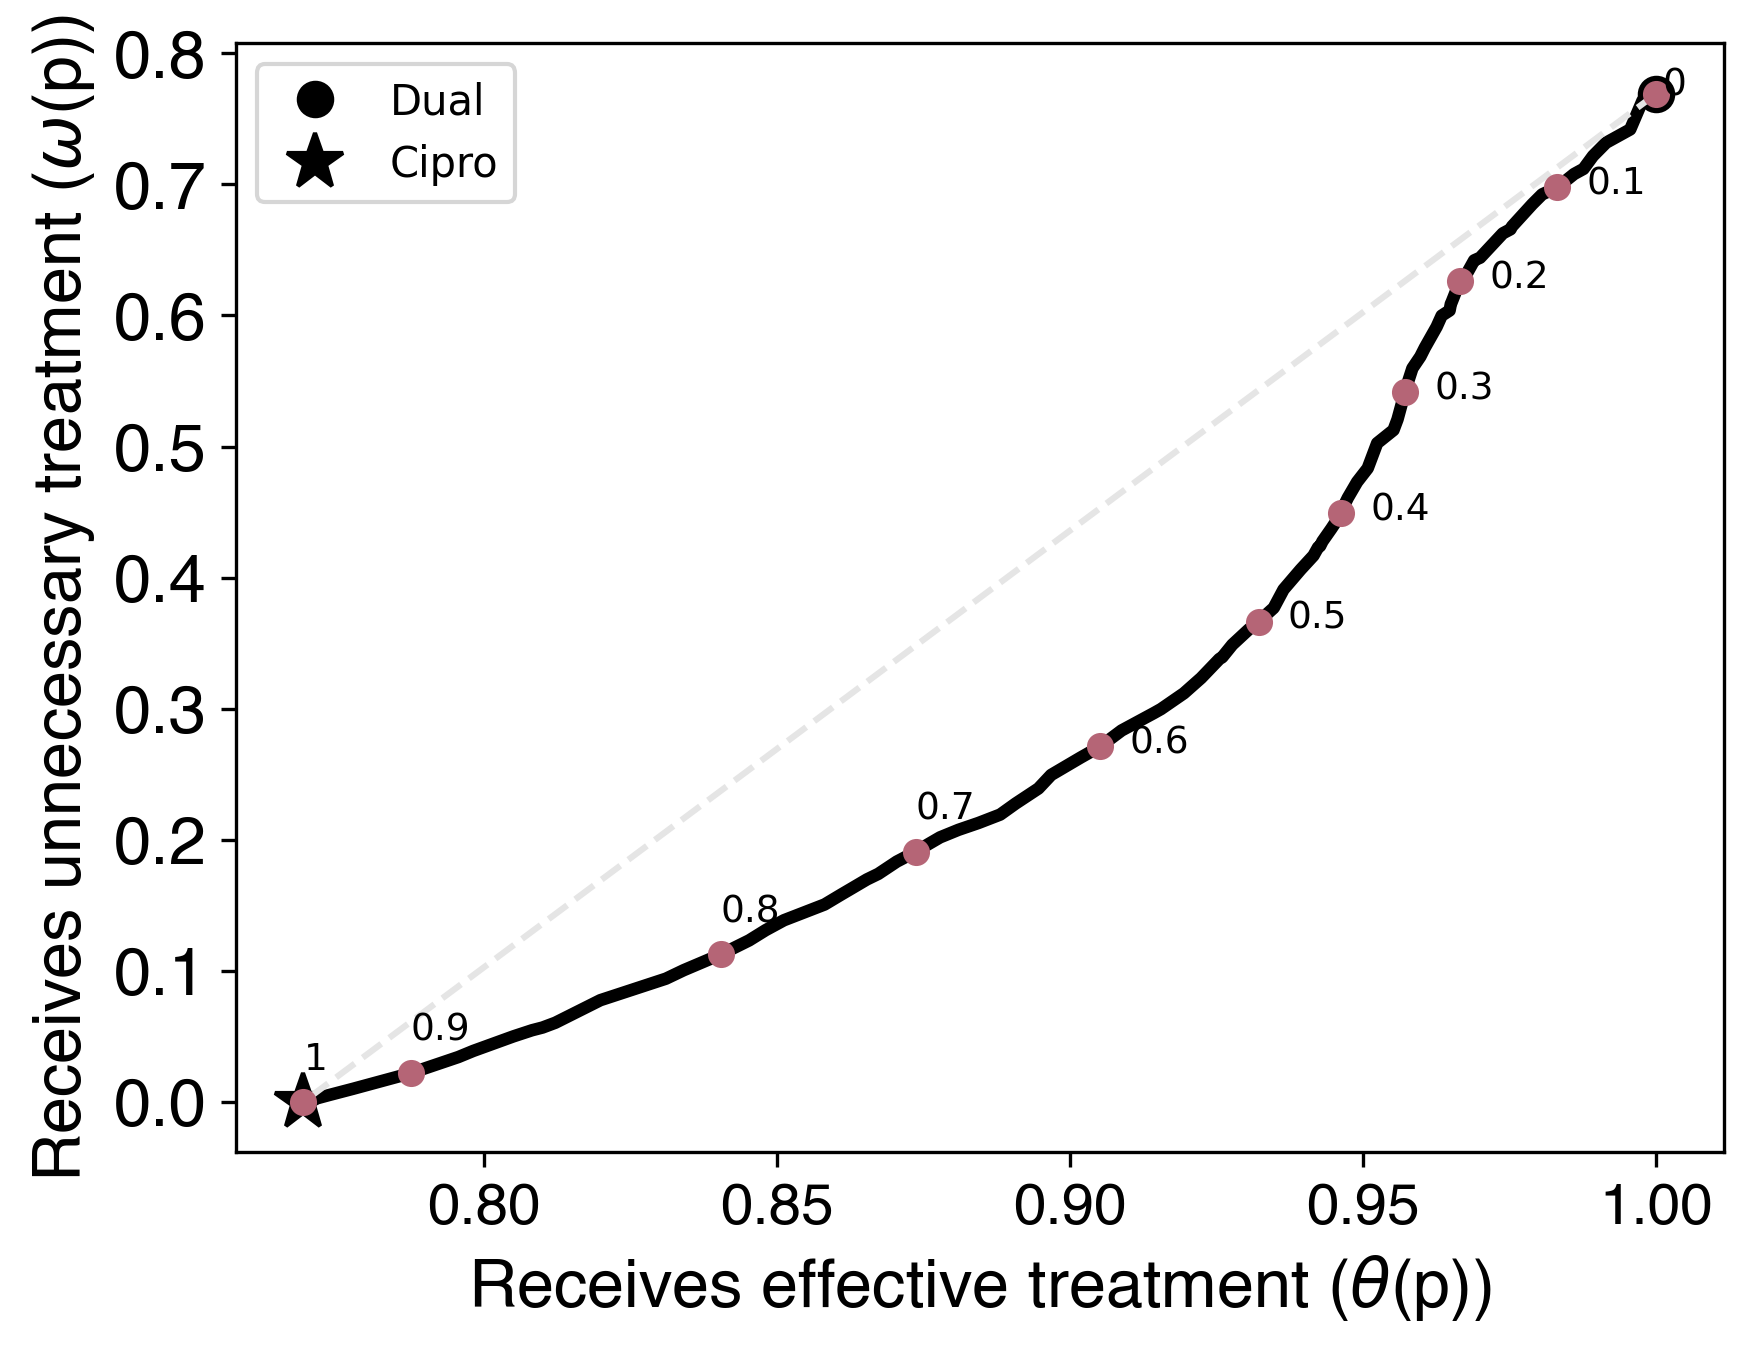

In [112]:
### Plotting overall proportion receiving effective and unnecessary treatment with all training data 

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)

plt.xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
plt.ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
plt.xticks(np.linspace(0,1,21), fontsize=14, **hfont)
plt.yticks(np.linspace(0,1,11), fontsize=16, **hfont)

plt.rcParams['figure.dpi'] = 300

plt.plot(1, 1 - cipro_R_prev_all, marker='.', ls='none', ms=16, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_all), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
plt.plot([1, 1-cipro_R_prev_all], [1-cipro_R_prev_all, 0], color = "#e5e5e5", linestyle="--")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
    if get_effective_threshold[index] > 0.996:
        plt.text(get_effective_threshold[index] + 0.001, incorrectly_get_X_threshold[index] - 0.001, text_for_graph[x], size = 9)
    elif (get_effective_threshold[index] > 0.9) & (get_effective_threshold[index] < 0.996):
        plt.text(get_effective_threshold[index] + 0.005, incorrectly_get_X_threshold[index] - 0.005, text_for_graph[x], size = 9)
    else:
        plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x], size = 9)
    x = x+1

#plt.savefig('Proportion_effective_unnecessary_all_workflow_paper.png')

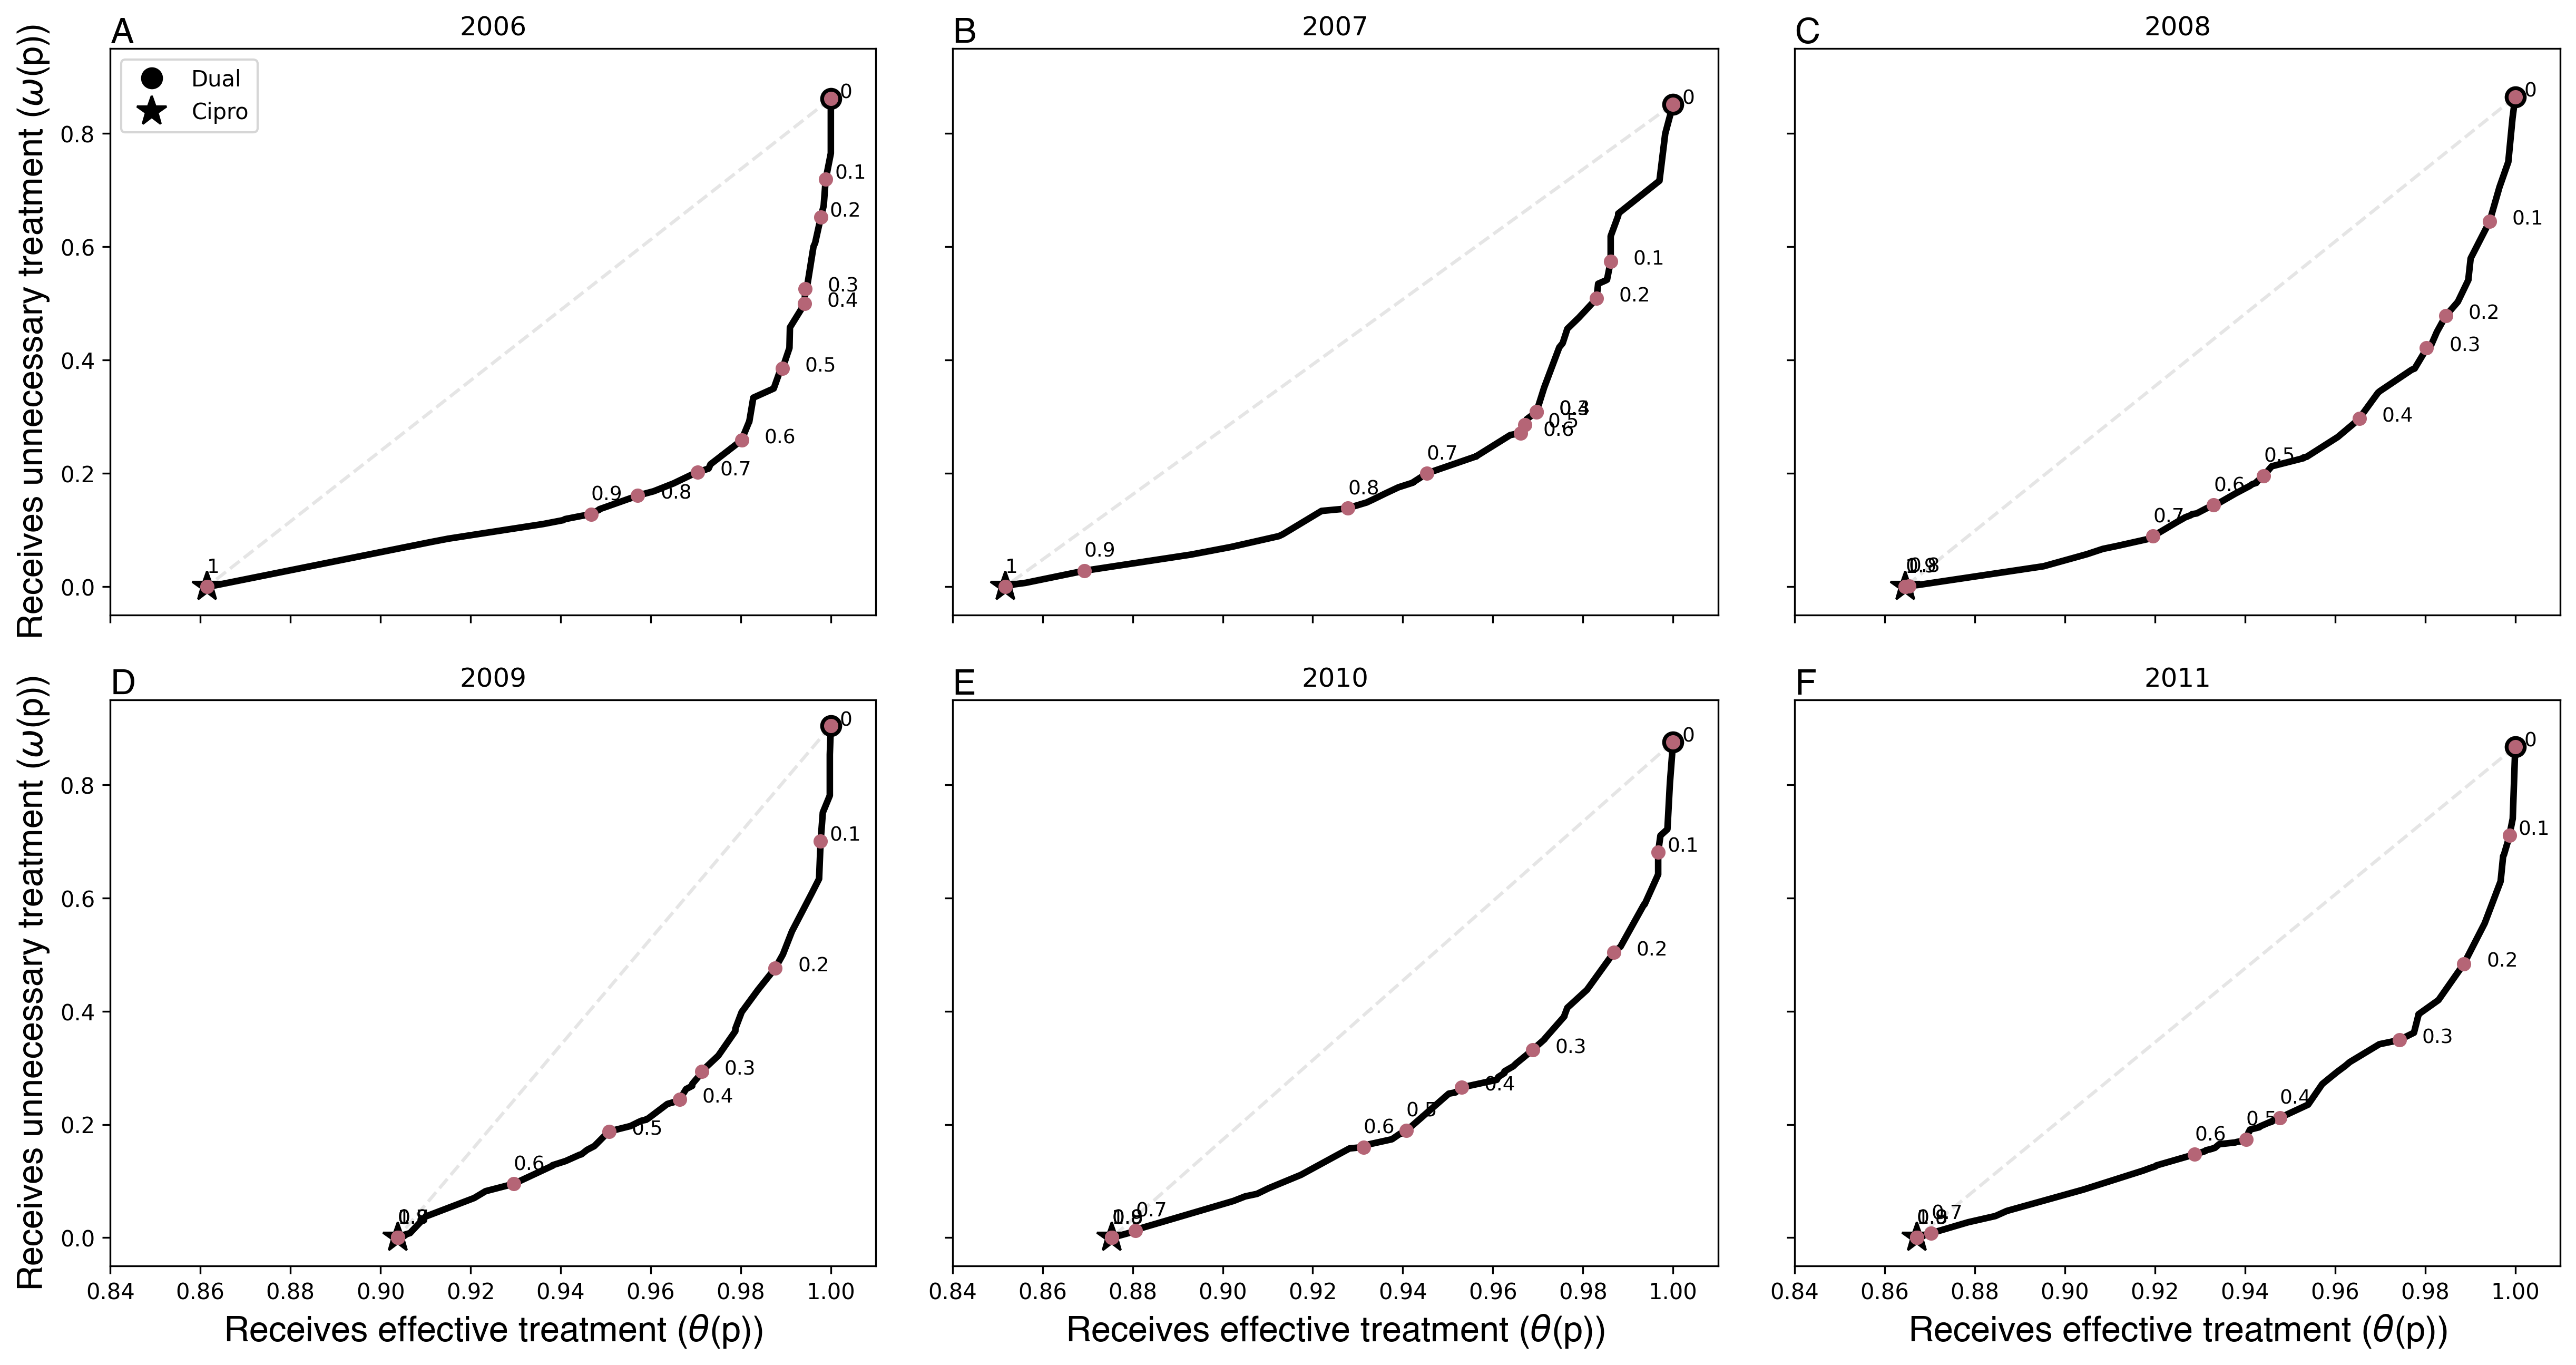

In [122]:
########### Now do proportion receiving effective and unnecessary treatment for years surrounding 2007 decision 
### now do a loop over different years to get the proportion receiving effective and unnecessary treatment 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )

threshold_seq = np.linspace(0,1,101)
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2006, 2007, 2008, 2009, 2010, 2011]
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
 #   if (i == 0) | (i == 3):
 #       axs[i].ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
 #   if(i == 3) | (i == 4) | (i == 5):
 #       axs[i].xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
#fig.set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
#fig.set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
for year in years: 
    #train
    years_train = np.array(range(year - 5, year))
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
    y_test = 1 - test_data['Susceptible']
    cipro_R_prev = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
    X_test, y_test = oversample.fit_resample(X_test,y_test)
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    get_effective_threshold_prev_5 = []
    incorrectly_get_X_threshold_prev_5 = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
    
        get_effective_threshold_prev_5.append(sensitivity_test * cipro_R_prev + (1 -  cipro_R_prev)) #q_p
        incorrectly_get_X_threshold_prev_5.append((1 - cipro_R_prev) * (1 - specificity_test)) #c_p
    x = 0
    axs[i].plot(get_effective_threshold_prev_5, incorrectly_get_X_threshold_prev_5,color = "black", linewidth = 3)
    axs[i].plot([1, 1-cipro_R_prev], [1-cipro_R_prev, 0], color = "#e5e5e5", linestyle="--")

    axs[i].set_ylim([0-0.05,0.95])
    axs[i].set_xlim([0.84, 1.01])
    if (i == 0) | (i == 3):
       axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
    if(i == 3) | (i == 4) | (i == 5):
        axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

    axs[i].plot(1, 1 - cipro_R_prev, marker='.', ls='none', ms=18, color = "black", label = "Dual")
    axs[i].plot((1-cipro_R_prev), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
    axs[i].title.set_text(year)
    if i == 0:
        axs[i].legend(loc = "upper left")

    for index in indices:
        axs[i].plot(get_effective_threshold_prev_5[index], incorrectly_get_X_threshold_prev_5[index], marker='.', ls='none', ms=11, color = "#b56576")
        if get_effective_threshold_prev_5[index] > 0.996:
            axs[i].text(get_effective_threshold_prev_5[index] + 0.002, incorrectly_get_X_threshold_prev_5[index] + 0.001, text_for_graph[x], size = 9)
        elif (get_effective_threshold_prev_5[index] > 0.95) & (get_effective_threshold_prev_5[index] < 0.996):
            axs[i].text(get_effective_threshold_prev_5[index] + 0.005, incorrectly_get_X_threshold_prev_5[index] - 0.005, text_for_graph[x], size = 9)
        else:
            axs[i].text(get_effective_threshold_prev_5[index], incorrectly_get_X_threshold_prev_5[index] + 0.025, text_for_graph[x], size = 9)
        x = x+1
    i += 1   
#plt.savefig('Proportion_effective_unnecessary_2006_2011_all_workflow_paper.png')

x
x


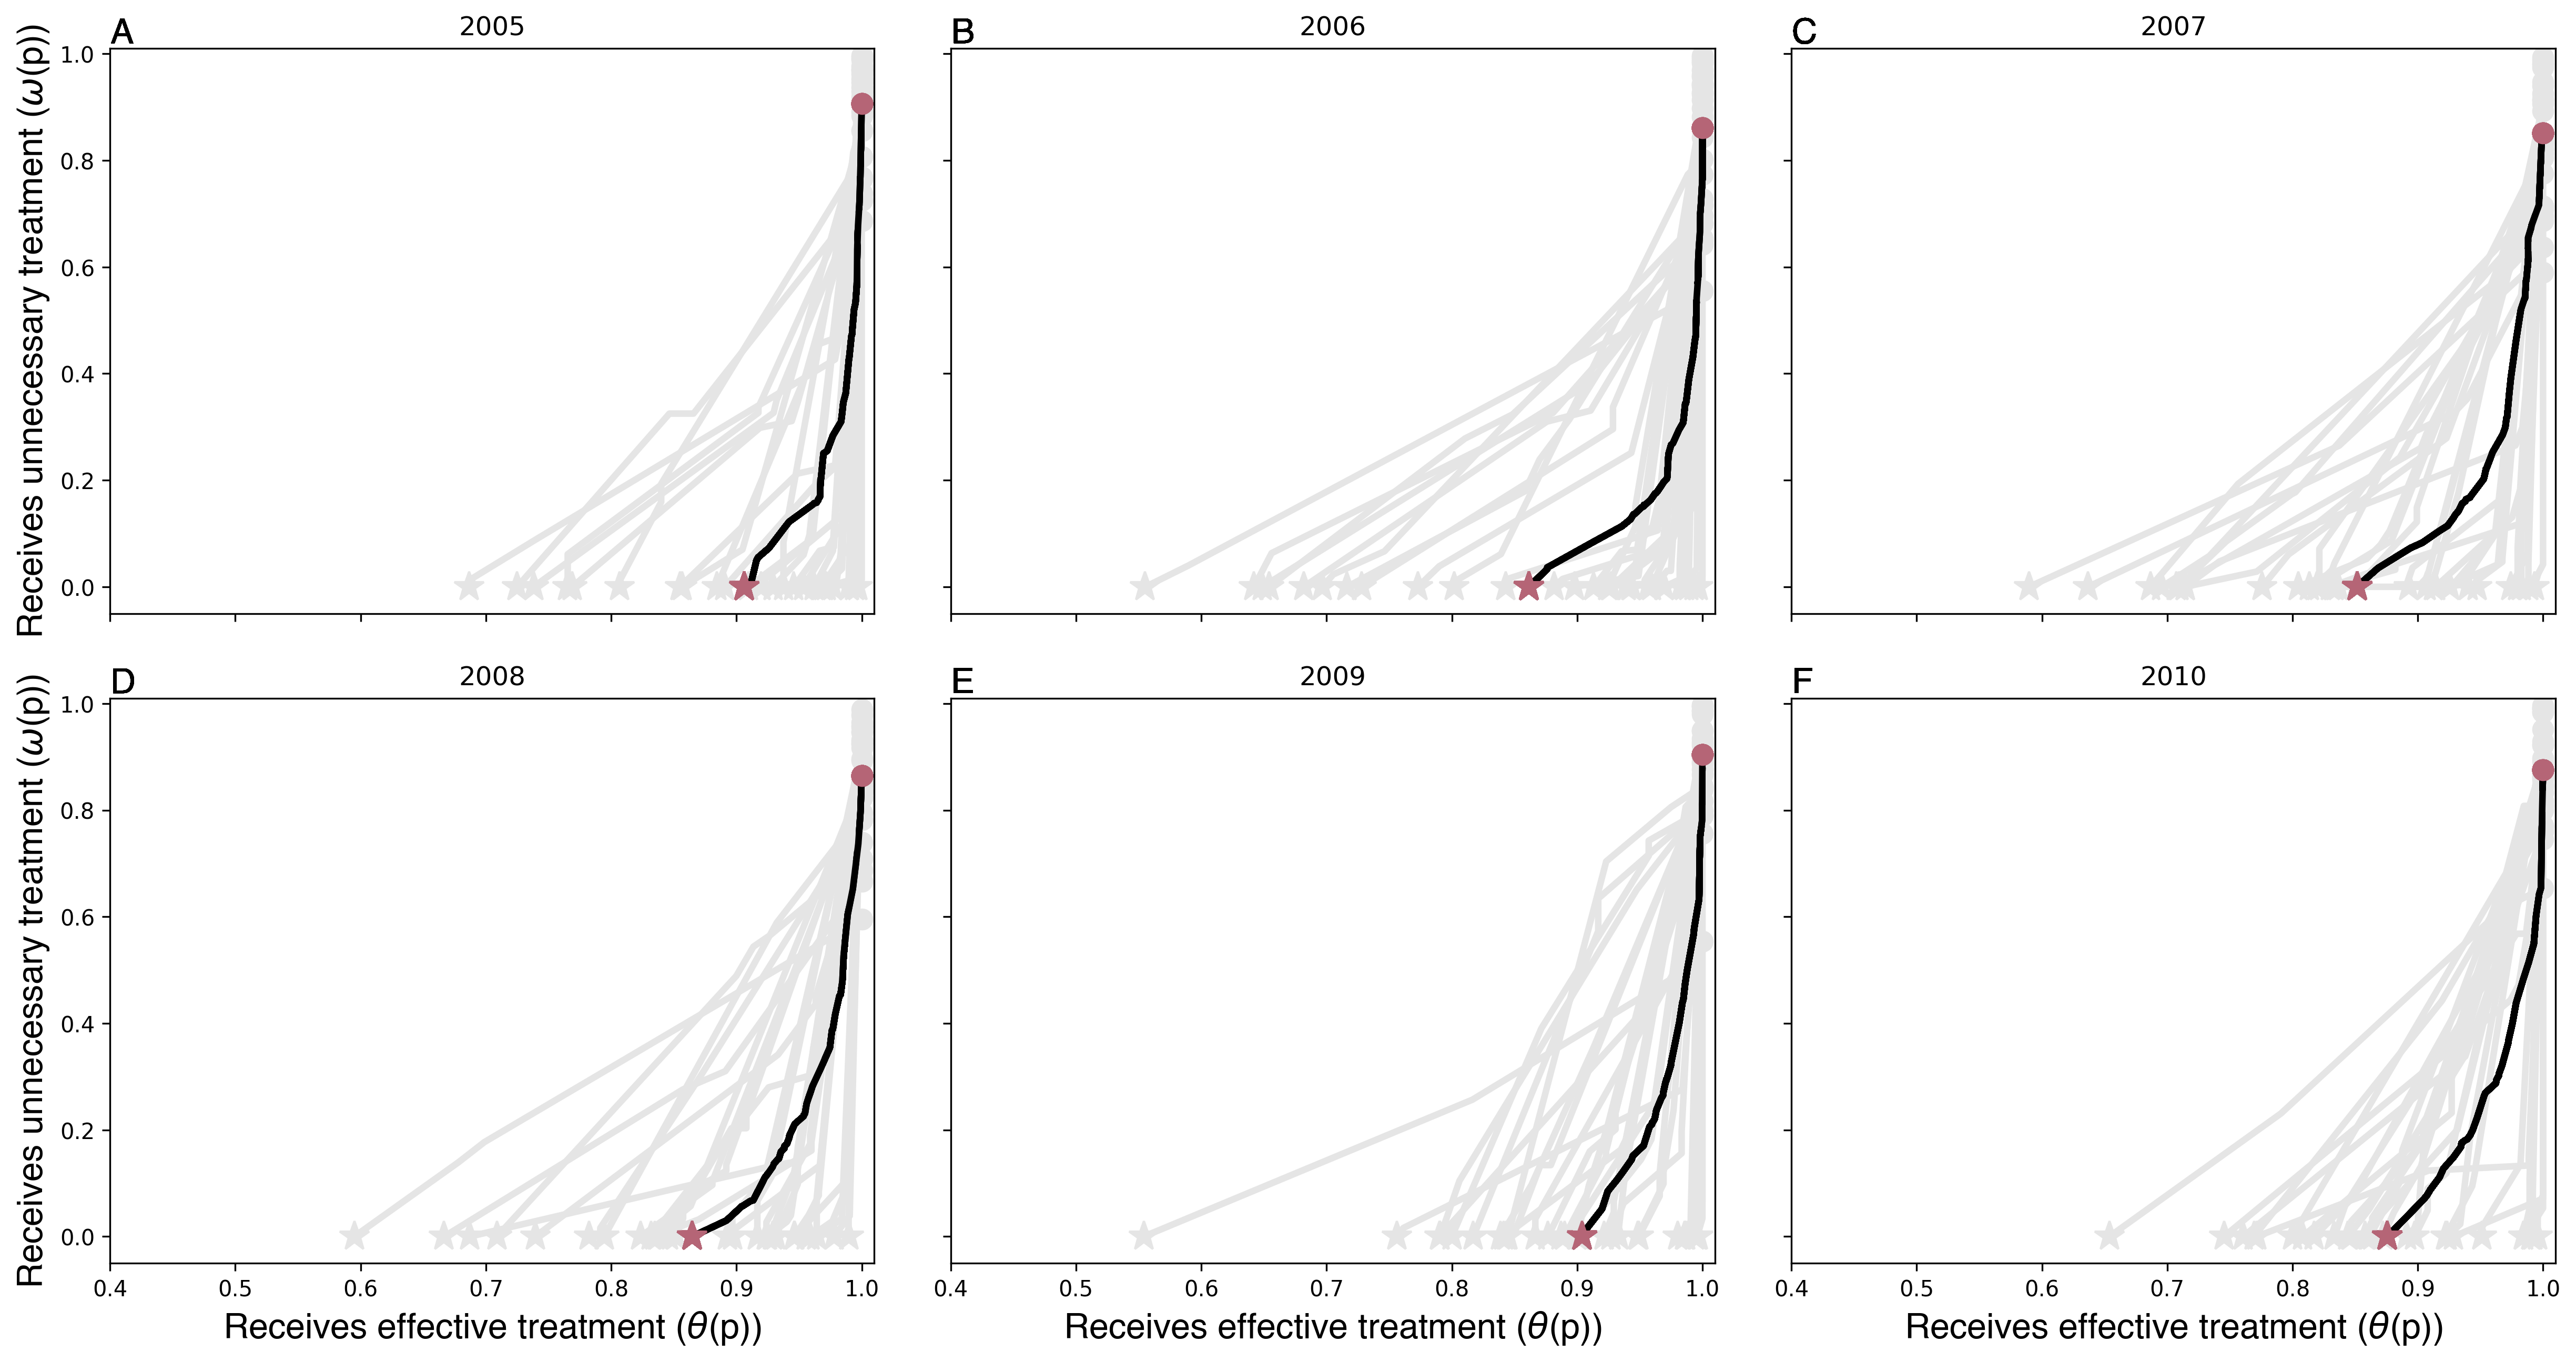

In [127]:
####### Try this with LOOCV as "error bars"... May be messy 

########### Now do proportion receiving effective and unnecessary treatment for years surrounding 2007 decision 
### now do a loop over different years to get the proportion receiving effective and unnecessary treatment 
### has LOOCV 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
## NEEDED FOR HYPERPARAMETER TUNING  - leave out for the moment 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

#space['activation'] = ['tanh', 'relu']
space['alpha'] = np.logspace(-1, 1, 10)[1:6]
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]


#### Loop set up 
test_years = [2005, 2006, 2007, 2008, 2009, 2010]
labels = ["A", "B", "C", "D", "E", "F" ]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')



fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
for year in test_years: 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)

    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
    y_test = 1 - test_data['Susceptible']
    cipro_R_prev = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
    X_test, y_test = oversample.fit_resample(X_test,y_test)

    ## before fitting the model, do hyperparameter tuning - LEAVE OUT FOR MOMENT 
    #search = RandomizedSearchCV(model_nn, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
    #result = search.fit(X, y)

    #model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= result.best_params_['hidden_layer_sizes'], alpha =  result.best_params_['alpha'], random_state=10, learning_rate = 'adaptive' )

    ## fit model w/hyperparameters 
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    get_effective_threshold_prev_5 = []
    incorrectly_get_X_threshold_prev_5 = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
    
        get_effective_threshold_prev_5.append(sensitivity_test * cipro_R_prev + (1 -  cipro_R_prev)) #q_p
        incorrectly_get_X_threshold_prev_5.append((1 - cipro_R_prev) * (1 - specificity_test)) #c_p
    x = 0
    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

          #train data - does not have clinic
        X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
                get_effective_threshold_region.append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
                incorrectly_get_X_threshold_region.append((1 - cipro_R) * (1 - specificity_test)) #c_p
              axs[i].plot(get_effective_threshold_region, incorrectly_get_X_threshold_region,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot([1, 1-cipro_R], [1-cipro_R, 0], color = "#e5e5e5", linestyle="--")

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   

          
          except ValueError:
            try:
              oversample = RandomOverSampler(sampling_strategy = 0.85,random_state=42)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
  
                get_effective_threshold_region.append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
                incorrectly_get_X_threshold_region.append((1 - cipro_R) * (1 - specificity_test)) #c_p
              x = 0
              axs[i].plot(get_effective_threshold_region, incorrectly_get_X_threshold_region,color = "#e5e5e5", linewidth = 3)

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")

            except ValueError:
              print('x')
              pass
          axs[i].plot(get_effective_threshold_prev_5, incorrectly_get_X_threshold_prev_5,color = "black", linewidth = 3)
          axs[i].plot(1, 1 - cipro_R_prev, marker='.', ls='none', ms=18, color = "#b56576")
          axs[i].plot((1-cipro_R_prev), 0, marker='*', ls='none', ms=14, color = "#b56576")
          axs[i].set_ylim([0-0.05,1.01])
          axs[i].set_xlim([0.4, 1.01])
          if (i == 0) | (i == 3):
            axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
          if(i == 3) | (i == 4) | (i == 5):
            axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
          axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
          axs[i].title.set_text(year)

    i += 1   
#plt.savefig('Graphs/Proportion_effective_unnecessary_2006_2011_all_LOOCV_workflow_paper_neural_network.png')

In [202]:
########### Try functionalised NN w/hyperparameter tuning and feature engineering 


def effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prevalence):

    get_effective_threshold = []
    incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
  
        get_effective_threshold.append(sensitivity_test * cipro_R_prevalence + (1 -  cipro_R_prevalence)) #q_p
        incorrectly_get_X_threshold.append((1 - cipro_R_prevalence) * (1 - specificity_test)) #c_p"
    return(get_effective_threshold, incorrectly_get_X_threshold)

def get_best_hyperparameters(model, cv, space, X_train, y_train):
        search = RandomizedSearchCV(model, space, scoring='roc_auc', n_iter=1,  n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X_train, y_train)
        return(result.best_params_)

def get_best_features(feature_names, model_fit, X_test, y_test):
    PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 10, random_state = 42)
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - 2 * PI.importances_std[q] > 0:
          important_features.append(feature_names[q]) #works cos they are in same order as the x columns
    return(important_features)


oversample = RandomOverSampler(sampling_strategy = 0.5, random_state=42)

def get_test_train_data_nn(CIP_data_no_drop, year, feature_names, oversample_size):
    years_train = np.array(range(year - 5, year))

    # first do for all clinics 
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[feature_names] #need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data['Susceptible']
    cipro_R = y_test.sum()/len(y_test) 
    X_test, y_test = oversample.fit_resample(X_test,y_test)
    return(test_data, train_data, X_train, y_train, X_test, y_test, cipro_R)

/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: Conv

x
x


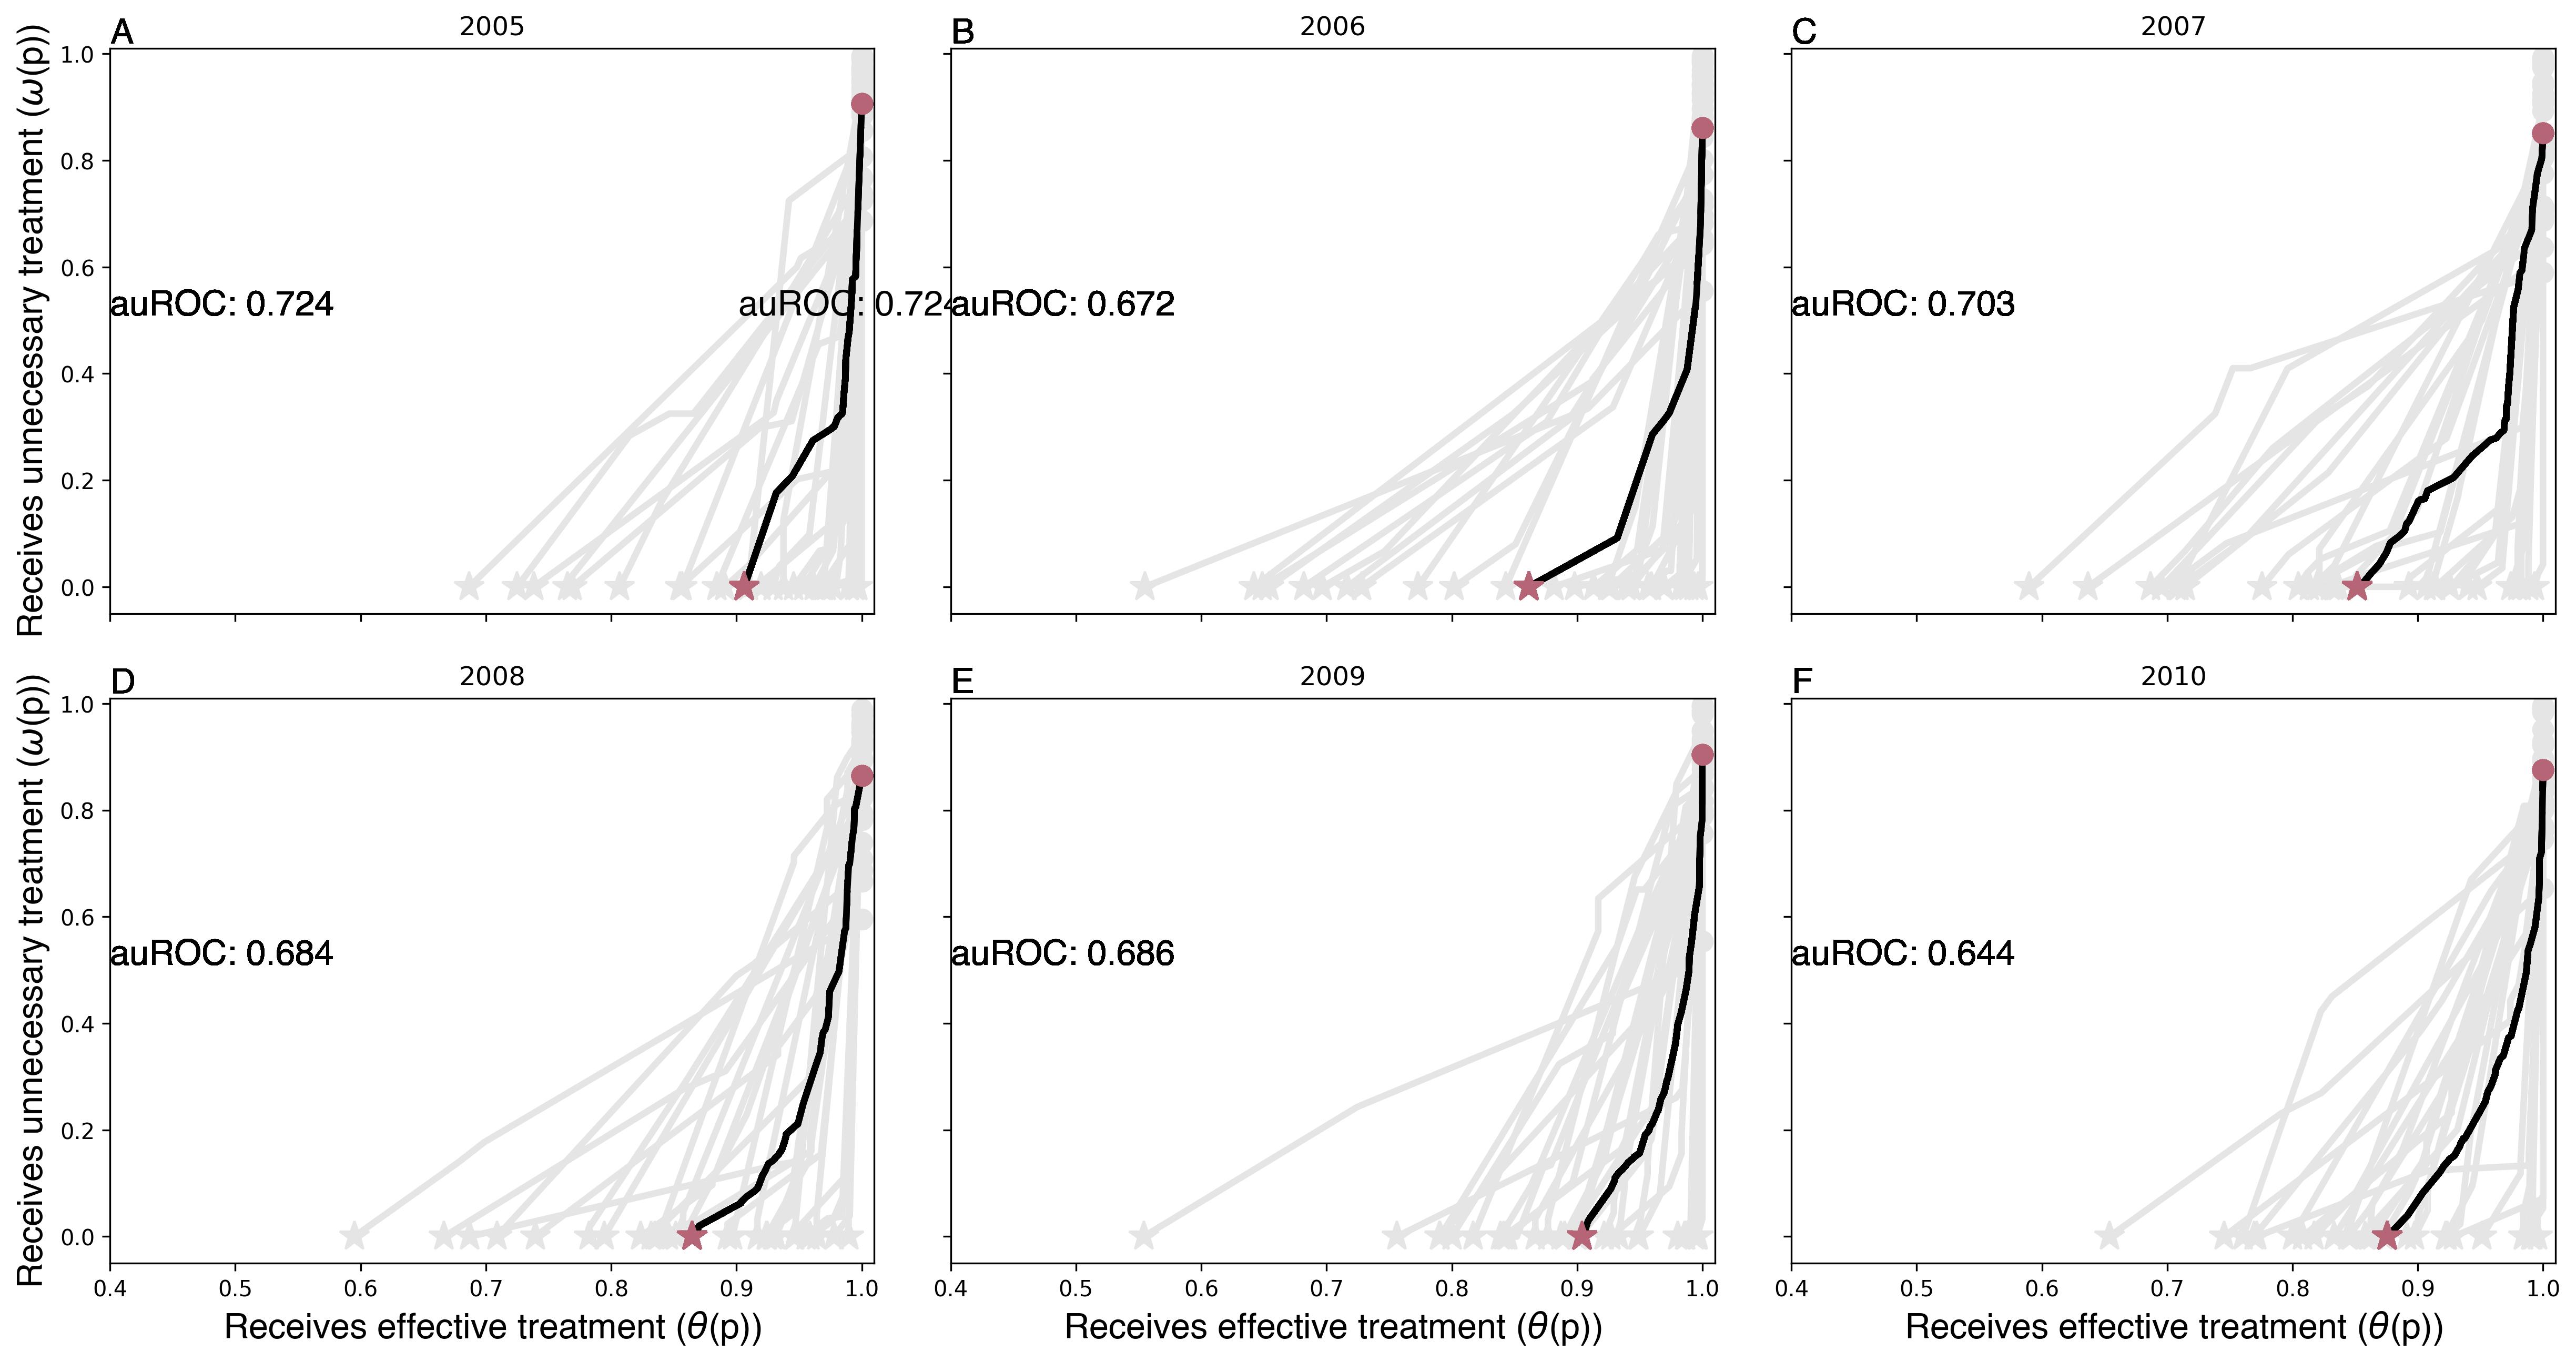

In [213]:
####### Try this with LOOCV as "error bars" AND LOOCV... May be messy and long

########### Now do proportion receiving effective and unnecessary treatment for years surrounding 2007 decision 
### now do a loop over different years to get the proportion receiving effective and unnecessary treatment 
### has LOOCV 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
## NEEDED FOR HYPERPARAMETER TUNING  - leave out for the moment 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

#space['activation'] = ['tanh', 'relu']
space = dict()

space['alpha'] = np.logspace(-1, 1, 10)[1:6]
#space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(12), (13), (14)]

## need for feature engineerig 
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']

#### Loop set up 
threshold_seq = np.linspace(0,1,101)

test_years = [2005, 2006, 2007, 2008, 2009, 2010]
#test_years = [2005, 2006]

labels = ["A", "B", "C", "D", "E", "F" ]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

### hyperparameters by year 
best_hyperparameters_by_year = {}
### best features by year
best_features_by_year = {}
### ROC by year 
ROC_by_year = {}


fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
for year in test_years: 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_nn(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, oversample_size = 0.5)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters = get_best_hyperparameters(model_nn, cv, space, X_train, y_train)
    best_hyperparameters_by_year.__setitem__(year, best_hyperparameters) 

    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters['hidden_layer_sizes'], alpha =  best_hyperparameters['alpha'], random_state=10, learning_rate = 'adaptive' )
    
     
    ## fit model w/hyperparameters 
    model_fit = model_nn.fit(X_train, y_train)
    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_test, y_test)
    best_features_by_year.__setitem__(year, important_features) 

    # get new tets/train data and refit model 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data_nn(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, oversample_size = 0.5)


    ## fit model w/hyperparameters 
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year.__setitem__(year, ROC)

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

          #train data - does not have clinic
        X_train = train_data[important_features]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[important_features]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot([1, 1-cipro_R], [1-cipro_R, 0], color = "#e5e5e5", linestyle="--")

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
   

          
          except ValueError:
            try:
              oversample = RandomOverSampler(sampling_strategy = 0.85,random_state=42)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
              
              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")

            except ValueError:
              print('x')
              pass
        axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
        axs[i].plot(1, 1 - cipro_R_prev, marker='.', ls='none', ms=18, color = "#b56576")
        axs[i].plot((1-cipro_R_prev), 0, marker='*', ls='none', ms=14, color = "#b56576")
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] - 0.5, f'auROC: {round(ROC, 3)}', fontsize = 16, **hfont)

        axs[i].set_ylim([0-0.05,1.01])
        axs[i].set_xlim([0.4, 1.01])
        if (i == 0) | (i == 3):
            axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
        if(i == 3) | (i == 4) | (i == 5):
            axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
        axs[i].title.set_text(year)

    i += 1   
#plt.savefig('Graphs/Proportion_effective_unnecessary_2006_2011_all_LOOCV_workflow_paper_neural_network.png')

In [215]:
##### Performance metric for nn model 

#performance metrics on training set of 2000-2010 and test set of 2011-2019 without MSW and midwest and with tuned hyperparameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#train data: 2000 - 2010
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)
model_fit = model_nn.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW',  'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
cipro_R_prev_all= y_test.sum()/len(y_test) #get prevalence overall before radndom oversampling
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_nn.predict(X_test)

ROC_AUC_neural_network = metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_nn:', ROC_AUC_neural_network) 

###F1 score

tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict).ravel()

precision = tp_test/(tp_test + fp_test)
recall = tp_test/(tp_test + fn_test)
f1_score = 2/(1/precision + 1/recall)
print("F1_me: ", f1_score)
###

from sklearn.metrics import f1_score

print("F1", f1_score(y_test, y_predict))
print("F1 macro: ", f1_score(y_test, y_predict, average = "macro"))

### MCC score
from sklearn.metrics import matthews_corrcoef
import math

MCC_me = ((tp_test*tn_test) - (fp_test*fn_test))/math.sqrt((tp_test + fp_test)*(tp_test + fn_test)*(tn_test + fp_test)*(tn_test + fn_test))
print("MCC:", MCC_me)

print("MCC:", matthews_corrcoef(y_test, y_predict))

## specificity and sensitivity for threshold = 0.5 

sensitivity_test  = tp_test  / (tp_test   + fn_test )
specificity_test   = tn_test / (tn_test + fp_test )

print("Sensitivity: ", sensitivity_test)
print("Specificity: ", specificity_test)

ROC_AUC_nn: 0.6148310841503746
F1_me:  0.5311024263149324
F1 0.5311024263149323
F1 macro:  0.5789644644129335
MCC: 0.21775318687129575
MCC: 0.21775318687129575
Sensitivity:  0.7061052175795627
Specificity:  0.5235569507211864


In [97]:
######### APPENDIX #############
######### Efficiency of model different datasets 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )

#loop setup

#   train - from 2000 to 2010, dropped MSW and Midwest
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
roc_auc_by_year = []
for year in years:
     print(year)
     # test - vary by year dropped SW and Other
     test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== year]
     X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
     y_test = 1 - test_data['Susceptible']
     if year == 2019:
          oversample = RandomOverSampler(sampling_strategy = 0.7,random_state=42)

     X_test, y_test = oversample.fit_resample(X_test,y_test)

    # train model 
     model_fit_train = model_nn.fit(X_train, y_train)
     y_predict_test = model_fit_train.predict(X_test)
     y_predict_proba = model_fit_train.predict_proba(X_test)

    #get ROC_AUC (implicit 0.5 threshold)
     roc_auc = metrics.roc_auc_score(y_test, y_predict_test)
     roc_auc_by_year.append(roc_auc)

2011
2012
2013
2014
2015
2016
2017
2018
2019


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.6895314478682988, 0.6774400684931507, 0.6601128703106419, 0.6427702044790653, 0.5694583751253761, 0.5635725429017161, 0.5655538508872591, 0.5527354765933445, 0.5596752191676033]


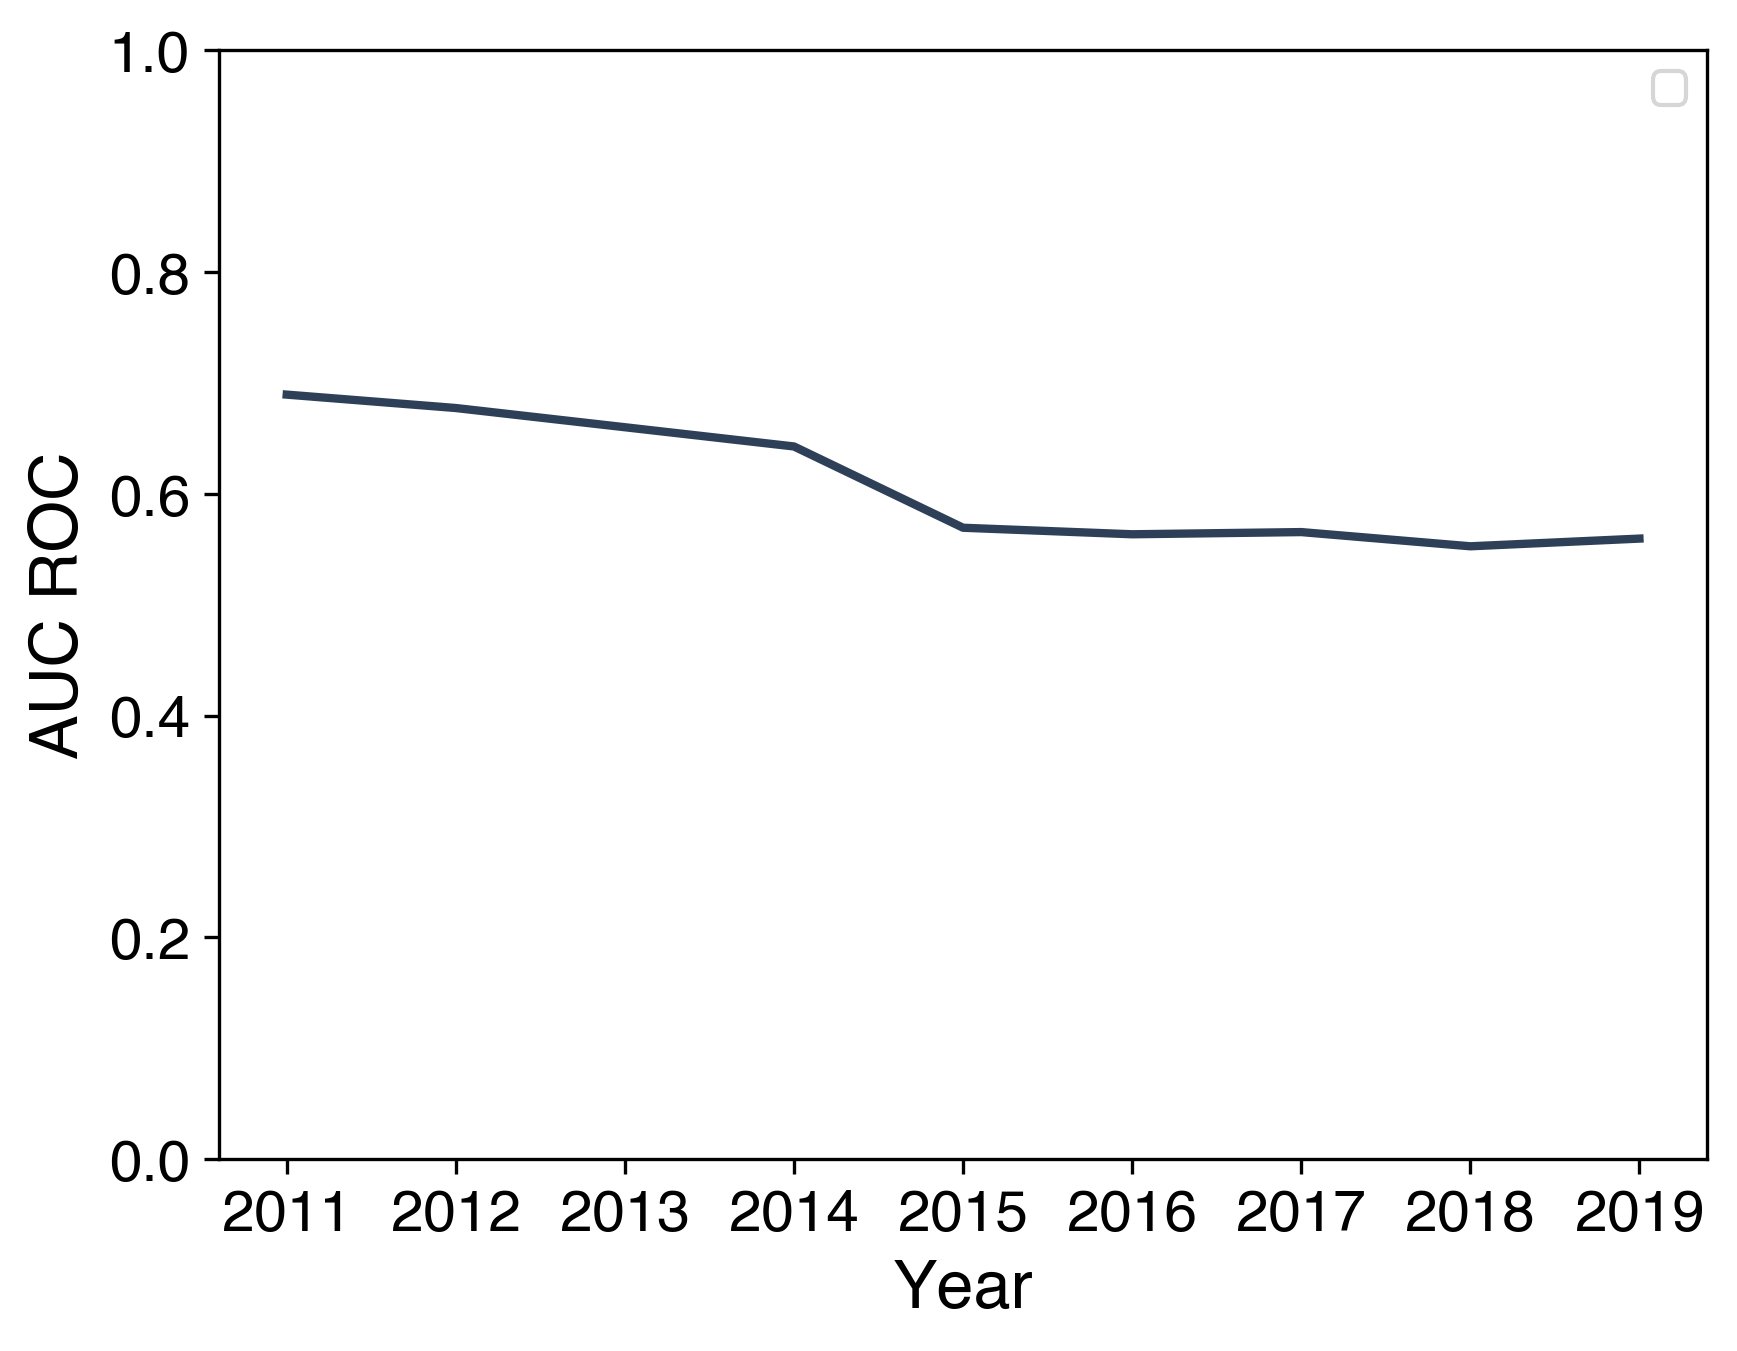

In [105]:
######### Efficiency of model different datasets - GRAPH 
print(roc_auc_by_year)
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.plot(years, roc_auc_by_year, color = "#2E4057", linestyle = 'solid', linewidth = 2)

plt.xlabel("Year", fontsize=16,**hfont)
plt.ylabel("AUC ROC", fontsize=16,**hfont)
plt.xticks(years, fontsize=14,**hfont)
plt.yticks(np.linspace(0,1,6), fontsize=14,**hfont)

plt.rcParams['figure.dpi'] = 300
plt.legend()
#plt.savefig('auROC_single_test_years_all_workflow_paper.png')


0.17065111758989315
0.3095982537903369
0.19202477739063106
0.2515190278221938
0.15925646822406425


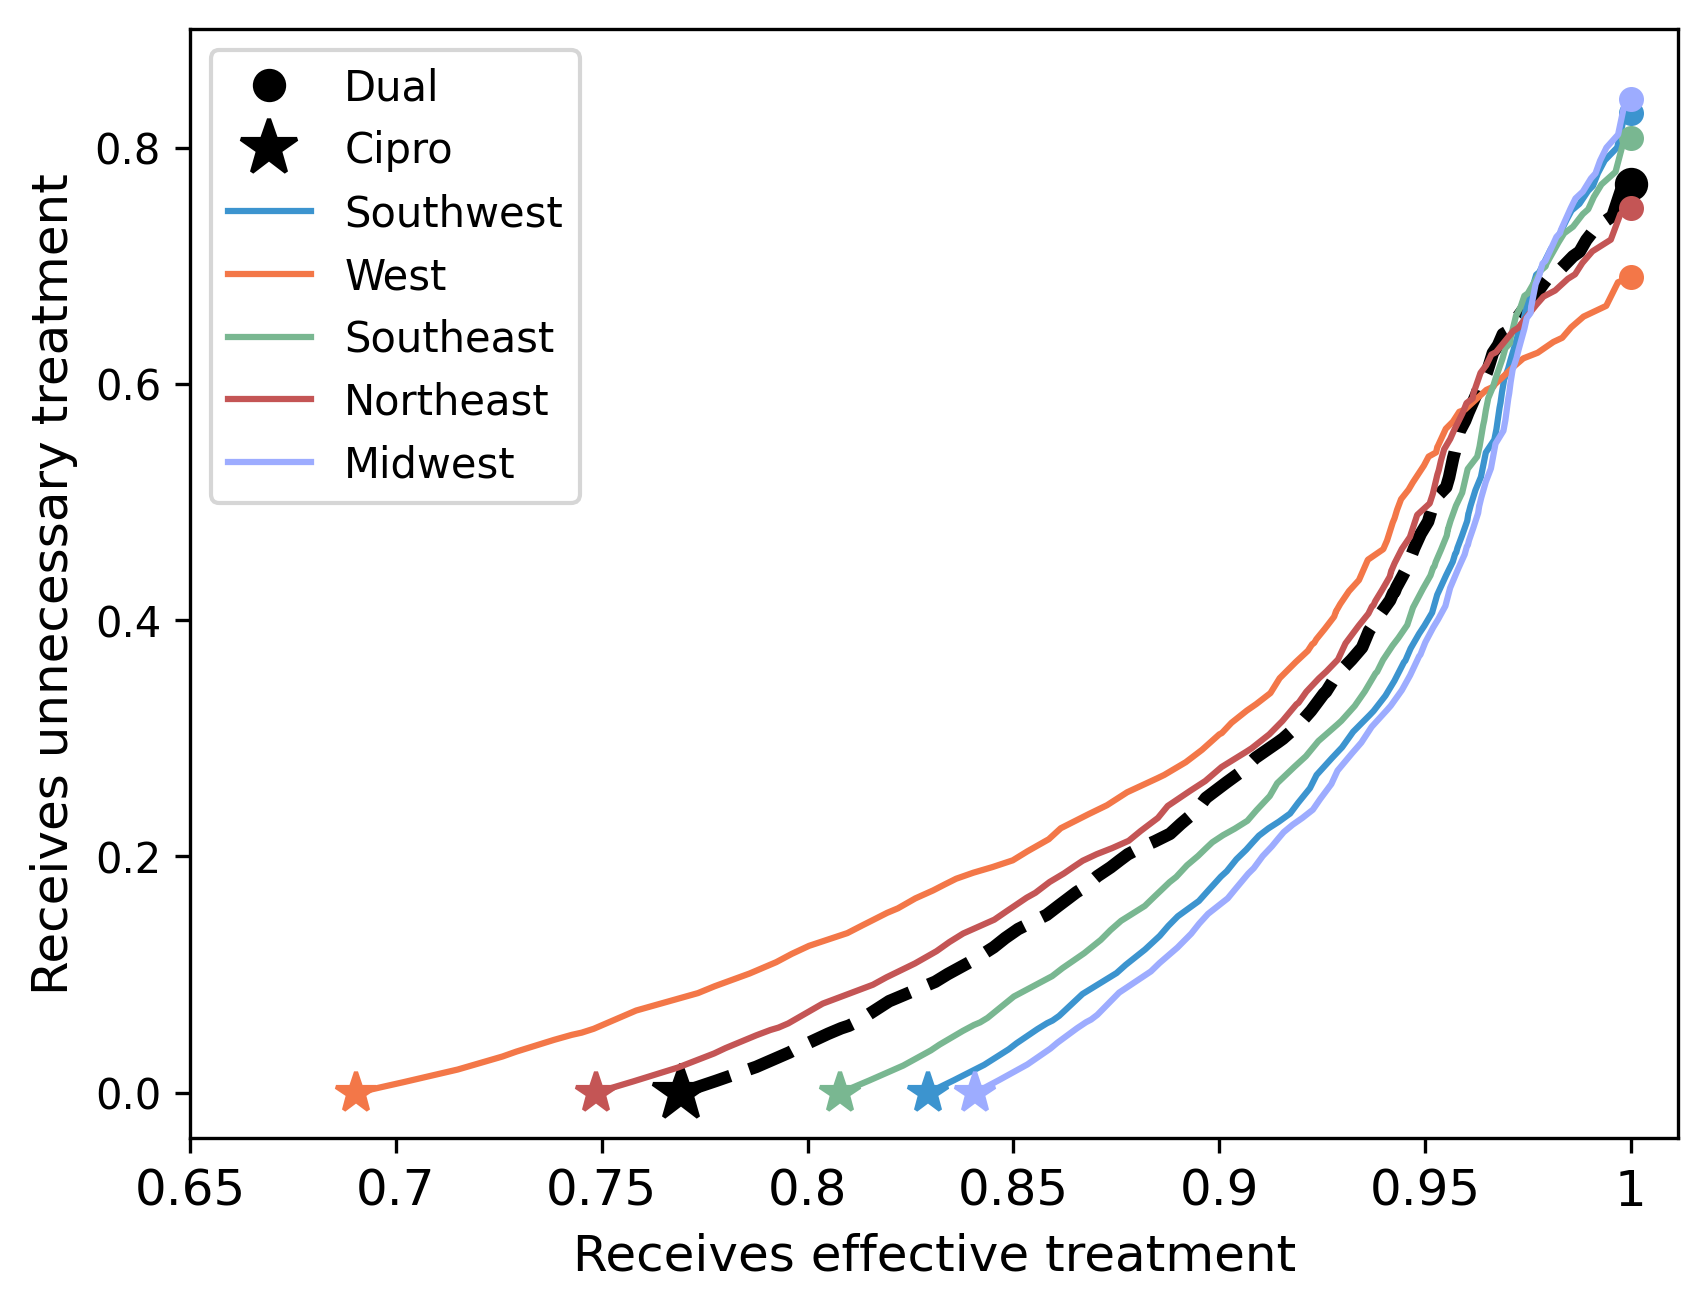

In [117]:
##### unnecessary and efficient by region 

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([ 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
cipro_R_prev_all = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
X_test, y_test = oversample.fit_resample(X_test,y_test)


model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

regions = test_data["REGION"].unique()

reistance_by_region  = []

for region in regions:
    CIP_data_region = test_data.loc[test_data['REGION'] == region]
    reistance_by_region.append(1 - CIP_data_region["Susceptible"].sum()/len(CIP_data_region))

### make main plot, then vary it by year 

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3, linestyle = "dashed" )

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1), ['0.65', '0.7','0.75', '0.8','0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.65)
plt.ylim(top = 0.9)
plt.plot(1, 1 - cipro_R_prev_all, marker='.', ls='none', ms=14, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_all), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
#plt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0

#for index in indices:
#    plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x])
#    x = x+1

x = 0
colours = ['#023e8a', '#0077b6', '#0096c7', '#00b4d8', '#90e0ef']
colours = ["#3C94CF", "#F37748", "#79B791", "#C45555", "#9DACFF"]
for cipro_R in reistance_by_region:
    print(cipro_R)
    get_effective_threshold_region = []
    incorrectly_get_X_threshold_region  = []
    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
  
        get_effective_threshold_region .append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
        incorrectly_get_X_threshold_region .append((1 - cipro_R) * (1 - specificity_test)) #c_p
    plt.plot(get_effective_threshold_region , incorrectly_get_X_threshold_region , color = colours[x], label = regions[x])
    plt.plot(1, 1 - cipro_R, marker='.', ls='none', ms=10, color = colours[x])
    plt.plot((1-cipro_R), 0, marker='*', ls='none', ms=10, color = colours[x])
    x += 1

plt.legend()
#plt.savefig('Proportion_effective_unnecessary_regional_all_workflow_paper.png')

In [108]:
print(cipro_R_prev_all)

0.23081886682486158
